# 보안 문자를 읽기 위한 OCR 모델

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/06/14<br>
**Last modified:** 2020/06/26<br>
**Description:** CNN, RNN 및 CTC 손실을 사용하여 OCR 모델을 구현하는 방법.

## 소개

이 예제는 Functional API로 빌드된 간단한 OCR 모델을 보여줍니다. CNN과 RNN을 결합하는 것 외에도 새 레이어를 인스턴스화하고 CTC 손실을 구현하기 위한 "엔드포인트 레이어"로 사용하는 방법도 보여줍니다. 레이어 서브클래싱에 대한 자세한 안내는 [이 페이지](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)를 확인하세요.
개발자 가이드에서.

## Setup

In [16]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## 데이터 로드: [Captcha Images](https://www.kaggle.com/fournierp/captcha-version-2-images)

In [17]:
url = "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip"
filename = os.path.join(os.getcwd(), "captcha_images_v2.zip")
keras.utils.get_file(filename, url)

os.makedirs("captcha_images_v2")

with zipfile.ZipFile("captcha_images_v2.zip", "r") as z_fp:
    z_fp.extractall("./")

데이터 세트에는 1040개의 보안 문자 파일이 `png` 이미지로 포함되어 있습니다. <br>
각 샘플의 레이블은 파일 이름(파일 확장명 제외)인 문자열입니다.<br>
모델 훈련을 위해 문자열의 각 문자를 정수로 매핑합니다.<br>
유사하게, 모델의 예측을 다시 문자열로 매핑해야 합니다. <br>
이를 위해 문자를 정수로 매핑하고 정수를 문자로 매핑하는 두 개의 사전을 유지 관리합니다.

In [43]:
data_dir = Path("./captcha_images_v2/")
images = sorted(list(map(str, list(data_dir.glob("*.png"))))[:5])
print(images)
labels = [ img.split(os.path.sep)[-1].split(".png")[0] for img in images]
print(labels)
characters = set(char for label in labels for char in label)
print(characters)

['captcha_images_v2\\226md.png', 'captcha_images_v2\\22d5n.png', 'captcha_images_v2\\2356g.png', 'captcha_images_v2\\23mdg.png', 'captcha_images_v2\\23n88.png']
['226md', '22d5n', '2356g', '23mdg', '23n88']
{'2', '6', 'g', '8', 'd', '3', '5', 'm', 'n'}


In [45]:

# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(max_length)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', 'm', 'g', 'c', 'd', 'p', 'w', 'b', '6', '7', '8', '3', '5', 'y', 'f', 'e', '4', 'x', 'n'}
5


## Preprocessing

In [62]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

print(char_to_num('w'))

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(num_to_char(7))

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
#     print(img.shape)
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
#     print(img.shape)
    # 6. Map the characters in label to numbers
#     print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(b'w', shape=(), dtype=string)


In [63]:
result = encode_single_sample(images[0], labels[0])
result["label"]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 9, 2, 5], dtype=int64)>

## 'Dataset' 객체 생성

In [64]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## 데이터 시각화

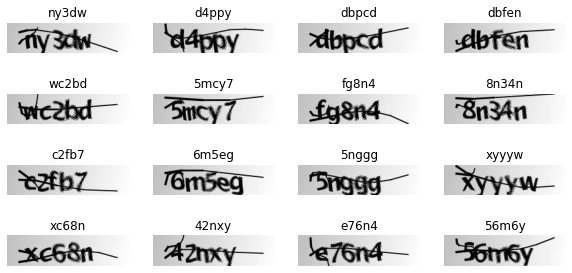

In [66]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## 모델

In [68]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
                                                             # (1,200,50,1)
    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)                                            # (1,200,50,32)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)        # (1,100,25,32)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)                                                   # (1,100,25,64)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)       # (1,50,12,64)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)  # (1,50,12*64)
    x = layers.Dense(64, activation="relu", name="dense1")(x)   # (1,50,12*64)(12*64,64)
    x = layers.Dropout(0.2)(x)                                  # (1,50,64)
                                                                # (N,T,D)
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x) # (1,50,64)(64,256)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)  # (1,50,256)(256,128)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)                                                        # (1,50,128)(64,19) => (1,50,21)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

## 훈련

In [69]:

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
59/59 [==============================] - 10s 112ms/step - loss: 20.9512 - val_loss: 16.3966
Epoch 2/100
59/59 [==============================] - 6s 103ms/step - loss: 16.3719 - val_loss: 16.3519
Epoch 3/100
59/59 [==============================] - 6s 103ms/step - loss: 16.3543 - val_loss: 16.3504
Epoch 4/100
59/59 [==============================] - 6s 97ms/step - loss: 16.3516 - val_loss: 16.3472
Epoch 5/100
59/59 [==============================] - 6s 102ms/step - loss: 16.3441 - val_loss: 16.3516
Epoch 6/100
59/59 [==============================] - 6s 104ms/step - loss: 16.3396 - val_loss: 16.3531
Epoch 7/100
59/59 [==============================] - 6s 103ms/step - loss: 16.3313 - val_loss: 16.3433
Epoch 8/100
59/59 [==============================] - 6s 100ms/step - loss: 16.3129 - val_loss: 16.3219
Epoch 9/100
59/59 [==============================] - 6s 103ms/step - loss: 16.3022 - val_loss: 16.2952
Epoch 10/100
59/59 [==============================] - 6s 104ms/step - los

## 추론

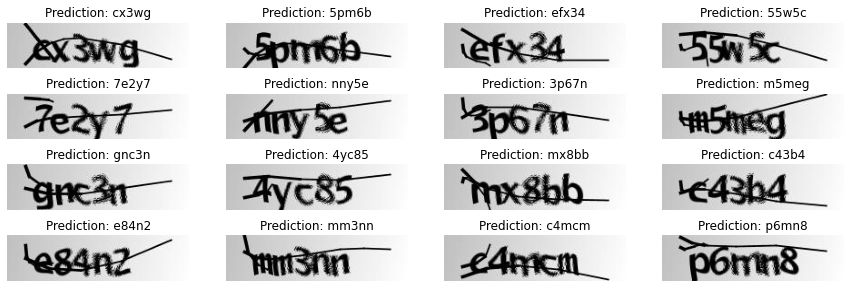

In [73]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
#     print(preds.shape)
#     print(preds[0,:5,:])
    pred_texts = decode_batch_predictions(preds)
#     print(pred_texts[0])
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()